## Requirements: -

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

## Data Collection

In [2]:
splits = {'train': 'emoji/train-00000-of-00001.parquet', 'test': 'emoji/test-00000-of-00001.parquet', 'validation': 'emoji/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/cardiffnlp/tweet_eval/" + splits["train"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.sample(10)

,text,label
10496,It's lit #ownthecampus #4sup @ UCLA - Student ...,4
28601,"Hey angel, tell me...do you ever try to come t...",3
5546,"Thankful for the jefita @ North Hollywood, Cal...",3
44356,Its saturday babe... (@ Venice Beach in Venice...,6
21828,At a bar having hot tea. @ Skyloft,19
28994,Got so lit that it was a #MELTillion Hope ya e...,4
30322,Three Amigos #gwenstefani @ The Forum,3
30297,@user #nyy #yankees @ Michaelann Byerly - Your...,2
37021,Hard work in my Artwork! TIME LAPSE Drawing of...,4
42763,Anybody who knows me well totally sees why I'm...,1


In [4]:
df.shape

(45000, 2)

### Checking for Null Values & Duplicates

In [5]:
df.isnull().sum()

,0
text,0
label,0


In [6]:
df.duplicated().sum()

np.int64(337)

In [7]:
df.drop_duplicates(inplace=True)

### Distribtion of Label

/tmp/ipython-input-1914902968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label',data=df , palette='pastel')


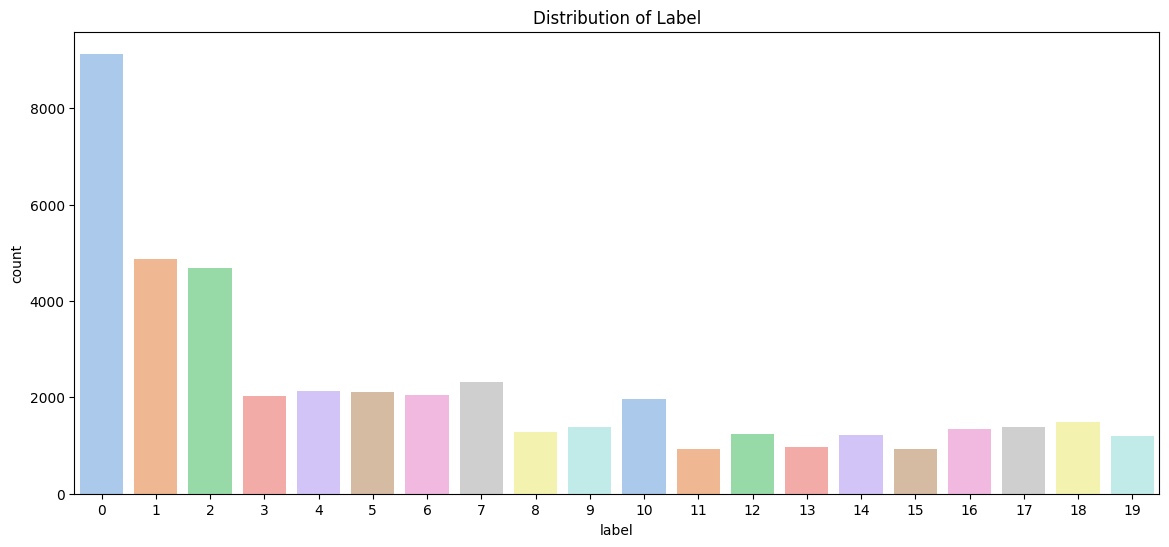

In [8]:
plt.figure(figsize=(14,6))
sns.countplot(x='label',data=df , palette='pastel')
plt.title("Distribution of Label")
plt.show()

### Sampling only 3 classes out of 20

In [9]:
three_labels = [0, 1, 2]

filtered_df = df[df["label"].isin(three_labels)]

sample_df = filtered_df.sample(n=1000, random_state=42)

### Dataset Shape After

In [10]:
sample_df.shape

(1000, 2)

In [11]:
sample_df.head()

,text,label
5529,Thankful for so much on this wonderful holiday...,0
18338,"Strong mind, soft heart. Healthy body, happy s...",0
609,#littlebeachhousemalibu # ️la @ Little Beach H...,0
15300,️Love this woman and all she stands for. Frien...,0
11722,️ @ Golden Gate Bridge Lookout,0


### Visualizing classes after sampling

/tmp/ipython-input-223766861.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=sample_df, palette='pastel')


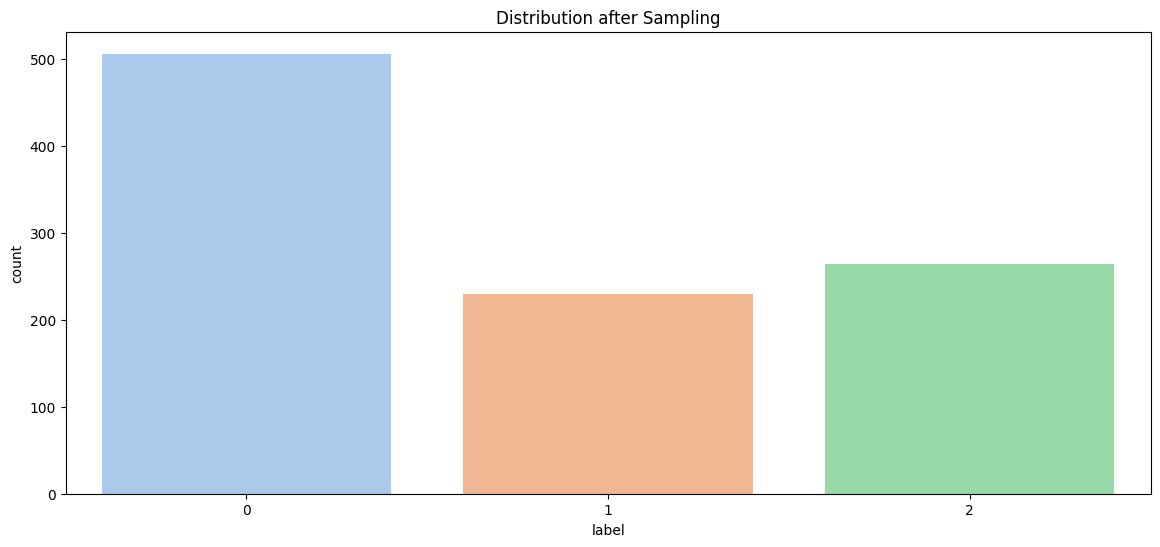

In [12]:
plt.figure(figsize=(14,6))
sns.countplot(x='label', data=sample_df, palette='pastel')
plt.title("Distribution after Sampling")
plt.show()

### Text Preprocessing

In [13]:
def clean_text(text):
    text = text.lower() # lowercasing
    text = re.sub(r"<.*?>", " ", text) # removing HTML tags
    text = re.sub(r"[^\x00-\x7F]+", " ", text) # removing emojis & non-ascii characters
    text = re.sub(r"\d+", " ", text) # remove numbers
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", " ", text) # removing extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

### Applying the Function to text

In [14]:
sample_df['text'] = sample_df['text'].apply(clean_text)

In [15]:
sample_df.head(10)

,text,label
5529,thankful for so much on this wonderful holiday...,0
18338,"strong mind, soft heart. healthy body, happy s...",0
609,littlebeachhousemalibu la little beach house m...,0
15300,love this woman and all she stands for. friend...,0
11722,golden gate bridge lookout,0
2521,coldplay! thank you user rosebowl vip suites,0
8579,oh my! i forgot to post about run yesterday we...,2
27946,yass the full like up for hsmf is out,1
6234,user was my favorite part of hard. goodvibes h...,1
18327,thanks for playing my song beautiful beverly h...,0


In [16]:
sample_df.to_json("corpus.json", orient='records', lines=False, force_ascii=False, index=False)

## Installing Dependencies

In [17]:
!pip install transformers sentence-transformers faiss-cpu streamlit gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 132.4 MB/s eta 0:00:00


## Initializing Model

In [18]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

id2label = model.config.id2label
print(id2label)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}


## Loading Data

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

df = pd.read_json("corpus.json")

### Testing the Model on the Dataset

In [20]:
label_map = {
    0: "positive",   # dataset's 0 → positive
    1: "neutral",    # dataset's 1 → neutral
    2: "negative"    # dataset's 2 → negative
}
df["label"] = df["label"].map(label_map)

# 3. Load model
classifier = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment"
)

# 4. Predict
preds = classifier(df["text"].tolist(), batch_size=32)

# 5. Convert model predictions (LABEL_0, LABEL_1, LABEL_2 → strings)
model_map = {0: "negative", 1: "neutral", 2: "positive"}
df["predicted"] = [model_map[int(p["label"].replace("LABEL_", ""))] for p in preds]

# 6. Evaluate
y_true = df["label"].tolist()
y_pred = df["predicted"].tolist()

print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("\n✅ Report:\n", classification_report(y_true, y_pred))

Device set to use cuda:0


✅ Accuracy: 0.431

✅ Report:
               precision    recall  f1-score   support

    negative       0.75      0.17      0.28       264
     neutral       0.22      0.43      0.29       230
    positive       0.59      0.57      0.58       506

    accuracy                           0.43      1000
   macro avg       0.52      0.39      0.38      1000
weighted avg       0.55      0.43      0.43      1000



## Save Model

In [21]:
classifier.model.save_pretrained('saved_model')

### Defining the texts to test the model on

In [22]:
texts = [
    "I love this product! It works perfectly.",
    "This is the worst movie I’ve ever watched.",
    "Meh, it was okay, nothing special.",
    "Absolutely fantastic experience, highly recommend!",
    "I am so disappointed, total waste of money.",
    "It’s fine, I don’t really care much.",
    "Amazing service, the staff was very friendly!",
    "Terrible idea, I regret trying this.",
    "Not bad, but not great either.",
    "Best purchase I’ve made this year!"
]

### Model Classifying the texts

In [23]:
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

classifier = pipeline(
    'sentiment-analysis',
    model='saved_model',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment'
)

preds = classifier(texts)

for text, pred in zip(texts, preds):
  sentiment = label_map[pred['label']]
  print(f"{text}")
  print(f"Predicted: {sentiment} (score={pred['score']:.4f})\n")

Device set to use cuda:0


I love this product! It works perfectly.
Predicted: positive (score=0.9920)

This is the worst movie I’ve ever watched.
Predicted: negative (score=0.9647)

Meh, it was okay, nothing special.
Predicted: positive (score=0.7213)

Absolutely fantastic experience, highly recommend!
Predicted: positive (score=0.9830)

I am so disappointed, total waste of money.
Predicted: negative (score=0.9803)

It’s fine, I don’t really care much.
Predicted: neutral (score=0.4766)

Amazing service, the staff was very friendly!
Predicted: positive (score=0.9874)

Terrible idea, I regret trying this.
Predicted: negative (score=0.9775)

Not bad, but not great either.
Predicted: negative (score=0.6046)

Best purchase I’ve made this year!
Predicted: positive (score=0.9717)



### Pros:
#### 📌 The Model Used is already pretained on positive, negative, neutral sentiments which makes it easier on this data.
#### 📌 Even though accuracy & f1_scores may issue bad performance, but the model acts familiar with sentiments.
### cons:
#### 📌 High imbalance towards positive class due to high tweets in that class, issue can be solved using smote or class weights.
#### 📌 That imbalance may issue an overlap between negative & neutral

## Loading Data for Embedding

In [24]:
import json

with open('corpus.json', 'r', encoding='utf-8') as f:
  data = json.load(f)


sentiment_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

documents = [item['text'] for item in data]
labels = [sentiment_map[item["label"]] for item in data]

## Initializing Sentence Model

In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(documents, convert_to_tensor=True)

print("Embedding Shape: ", embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding Shape:  torch.Size([1000, 384])


## Vector DB

In [26]:
import faiss

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings.cpu().numpy())

emotion_model = pipeline(
    'sentiment-analysis',
    model = '/content/saved_model',
    tokenizer=tokenizer,
    top_k = None
)

Device set to use cuda:0


### retrieve function

In [27]:
def retrieve_responses(query, k=3):
    emotion_pred = emotion_model(query)[0]
    sentiment_map = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive"
    }
    detected_emotion = sentiment_map[max(emotion_pred, key=lambda x: x['score'])['label']]

    query_emb = model.encode([query], convert_to_numpy=True)

    D, I = index.search(query_emb, k*5)

    candidates = [(documents[i], labels[i], D[0][j]) for j, i in enumerate(I[0])]

    filtered = [c for c in candidates if c[1] == detected_emotion]

    results = (filtered[:k] if len(filtered) >= k else candidates[:k])

    return detected_emotion, results

In [28]:
query = 'i feel sad and heartbroken today!'
emotion, response = retrieve_responses(query, k=3)

print(f"Detected Emotion: {emotion}")
for i , (text, label, dist) in enumerate(response, 1):
  print(f"{i}, {text} [{label}] (distance={dist: 4f})")

Detected Emotion: negative
1, home is where the heart is i just wanted to take a moment amp say how grateful i truly am [negative] (distance= 0.995846)
2, from time to time my heart feels like it is going to explode, but not to worry, it s all from [negative] (distance= 1.043151)
3, but what fills my heart most is the special time we share with familia and friends! merry [negative] (distance= 1.198942)


### generate response function

### Chatbot Response

In [30]:
!pip install sounddevice

In [32]:
!apt-get install libportaudio2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 0s (158 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero_v2.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/loc

In [36]:
!apt-get update && apt-get install espeak

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,006 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InReleas

In [43]:
from gtts import gTTS
import os

def speak_text(text):
    tts = gTTS(text=text, lang="en")
    tts.save("response.mp3")
    os.system("mpg123 response.mp3")  # install mpg123 if needed


In [75]:
import torch
import librosa
from IPython.display import Javascript, display, Audio
from google.colab import output
from base64 import b64decode
import numpy as np
import time
from gtts import gTTS
import IPython.display as ipd
from transformers import pipeline

# -------- Speech-to-Text (Whisper) --------
stt_pipeline = pipeline(
    'automatic-speech-recognition',
    model='openai/whisper-small',
)
RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  recorder = new MediaRecorder(stream);
  chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();
  await sleep(time);
  recorder.onstop = async () => {
    blob = new Blob(chunks, { type: 'audio/wav' });
    text = await b2text(blob);
    resolve(text);
  };
  recorder.stop();
});
"""

def record_audio(duration=10):
    print("Preparing to record... Please wait.")
    time.sleep(2)  # Short delay to ensure user is ready
    print("Speak now!")
    display(Javascript(RECORD))
    print(f"Recording for {duration} seconds...")
    s = output.eval_js(f'record({duration * 1000})')
    b = b64decode(s.split(',')[1])
    audio_file = 'output.wav'
    with open(audio_file, 'wb') as f:
        f.write(b)
    print("Recording finished and saved as", audio_file)
    return audio_file

# Moved speak_text definition here
def speak_text(text): # Removed filename argument
  try:
    tts = gTTS(text=text, lang='en') # Changed text=text to text
    tts.save('bot_response.mp3') # Used default filename
    return ipd.Audio('bot_response.mp3', autoplay=True)
  except Exception as e:
    print(f"Error in speak_text: {e}")
    return None


try:
  audio_file = record_audio(duration=10)
except Exception as e:
  print(f"Error recording audio: {e}")
  print("please ensur mic access is enabled !")
  raise

try:
  audio_input, sr = librosa.load(audio_file, sr=16000)
  print(f"Audio loaded successfully. Duration: {librosa.get_duration(y=audio_input, sr=sr)} seconds")
  # Check if audio is silent
  if np.max(np.abs(audio_input)) < 0.01:  # Threshold for silence
        print("Warning: Audio appears to be silent or very quiet. Try speaking louder or closer to the microphone.")
except Exception as e:
    print(f"Error loading audio file: {e}")
    raise




def generate_response(user_input):
    emotion, responses = retrieve_responses(user_input, k=3)

    templates = "\n".join([f"- {r[0]}" for r in responses])
    prompt = (
        f"The user is feeling {emotion}. "
        f"Final response:"
    )

    final_response = f"{prompt}\n\n I'M a Emotion Analyst."

    # For the audio output, we need to synthesize the response
    # Using the speak_text function defined earlier
    audio_output_path = 'bot_response.mp3'
    speak_text(final_response) # Removed filename argument

    return final_response, audio_output_path


audio_file = record_audio(duration=5)
user_input = stt_pipeline(audio_file)["text"]
print("You (speech→text):", user_input)

response = generate_response(user_input)
print("\nBot:", response, "\n")

# Bot speaks
speak_text(response[0])

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


Preparing to record... Please wait.
Speak now!


<IPython.core.display.Javascript object>

Recording for 10 seconds...
Recording finished and saved as output.wav
Audio loaded successfully. Duration: 9.96 seconds
Preparing to record... Please wait.


/tmp/ipython-input-4196860473.py:73: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_input, sr = librosa.load(audio_file, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Speak now!


<IPython.core.display.Javascript object>

Recording for 5 seconds...
Recording finished and saved as output.wav
You (speech→text):  I am very happy right now.

Bot: ("The user is feeling positive. Final response:\n\n I'M a Emotion Analyst.", 'bot_response.mp3') 



## Deployment Using Streamlit & Gradio

In [76]:
%%writefile app.py
import streamlit as st

st.title("🧠 Emotion Analysis RAG Chatbot")
st.write("Talk or type your message and get empathetic responses (positive, negative, neutral).")

# --- Input options ---
input_mode = st.radio("Choose input method:", ["Type", "Speak"])

user_input = ""

if input_mode == "Type":
    user_input = st.text_area("✍️ Your message:")

elif input_mode == "Speak":
    audio_file = st.file_uploader("🎙️ Upload a WAV audio file", type=["wav", "mp3", "m4a"])
    if audio_file:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp_file:
            tmp_file.write(audio_file.read())
            tmp_path = tmp_file.name
        st.success("✅ Audio uploaded! Transcribing...")
        user_input = stt_pipeline(tmp_path)["text"]
        st.write(f"**You (speech→text):** {user_input}")

# --- Get Response ---
if st.button("Get Response"):
    if user_input.strip():
        response = generate_response(user_input)

        st.write("### 🤖 Bot Response")
        st.write(response)

        # --- Convert bot reply to speech (gTTS) ---
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp_audio:
            tts = gTTS(text=response, lang="en")
            tts.save(tmp_audio.name)
            st.audio(tmp_audio.name, format="audio/mp3", autoplay=True)

Overwriting app.py


In [77]:
import gradio as gr

demo = gr.Interface(
    fn=generate_response,
    inputs=[
        gr.Textbox(label="✍️ Enter your message"),
        gr.Audio(sources=["microphone", "upload"], type="filepath", label="🎤 Speak your message"),
    ],
    outputs=[
        gr.Textbox(label="🤖 Chatbot Response"),
        gr.Audio(type="filepath", label="🔊 Bot Voice Reply"),
    ],
    title="🧠 Emotion-Aware RAG Chatbot",
    description="Talk or type to the chatbot. It classifies input as positive/neutral/negative and responds empathetically (text + voice)."
)

if __name__ == "__main__":
    demo.launch()

/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1052: UserWarning: Expected 1 arguments for function <function generate_response at 0x7bfb63769b20>, received 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1060: UserWarning: Expected maximum 1 arguments for function <function generate_response at 0x7bfb63769b20>, received 2.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3f5e2e85f4dcfaf8f0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [41]:
!pip install gtts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
